# Lab Exercise #3 


In [1044]:
#%pip install tensorflow
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install pydot
#%pip install scipy

## Dataset Validation

In [1045]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

## Hyperparameters


In [1046]:
# For easy modification
image_size = (64, 64)
batch_size = 32
epochs = 5

## Loading the Dataset

In [1047]:
import tensorflow as tf

# Load Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

# Load Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 978 files belonging to 3 classes.
Using 783 files for training.
Found 978 files belonging to 3 classes.
Using 195 files for validation.


## Data Profiling and Visualization

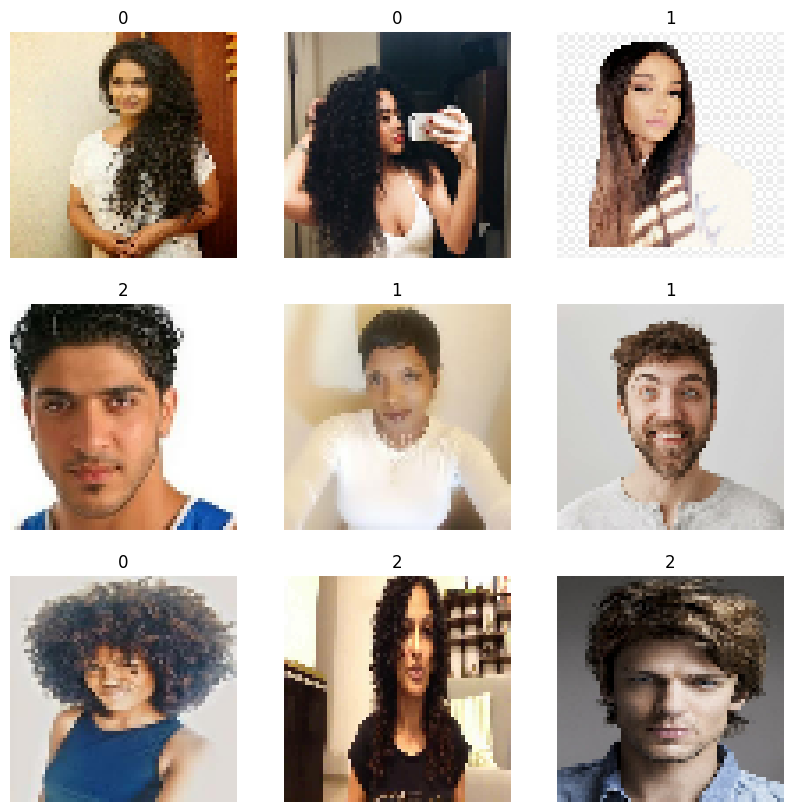

In [1048]:
import matplotlib.pyplot as plt
import numpy as np

# Shuffle the dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for images, labels in train_ds_shuffled.take(1):  # Take a batch of images from the shuffled dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

## Data Augmentation

In [1049]:
import tensorflow as tf

def augment_data(image, label):
    #image = tf.image.random_flip_left_right(image)  # Randomly flip images horizontally
    #image = tf.image.random_flip_up_down(image)  # Randomly flip images vertically
    # image = tf.image.random_brightness(image, max_delta=0.1)  # Adjust brightness randomly
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast randomly
    image = random_rotate_image(image)
    return image, label


def random_rotate_image(image):
    random_angle = tf.random.uniform([], minval=0, maxval=12, dtype=tf.int32) * 30  # Generate a random angle between 0 and 330 degrees
    rotated_image = tf.image.rot90(image, k=random_angle // 90)   # Rotate the image by the random angle
    return rotated_image

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(augment_data)


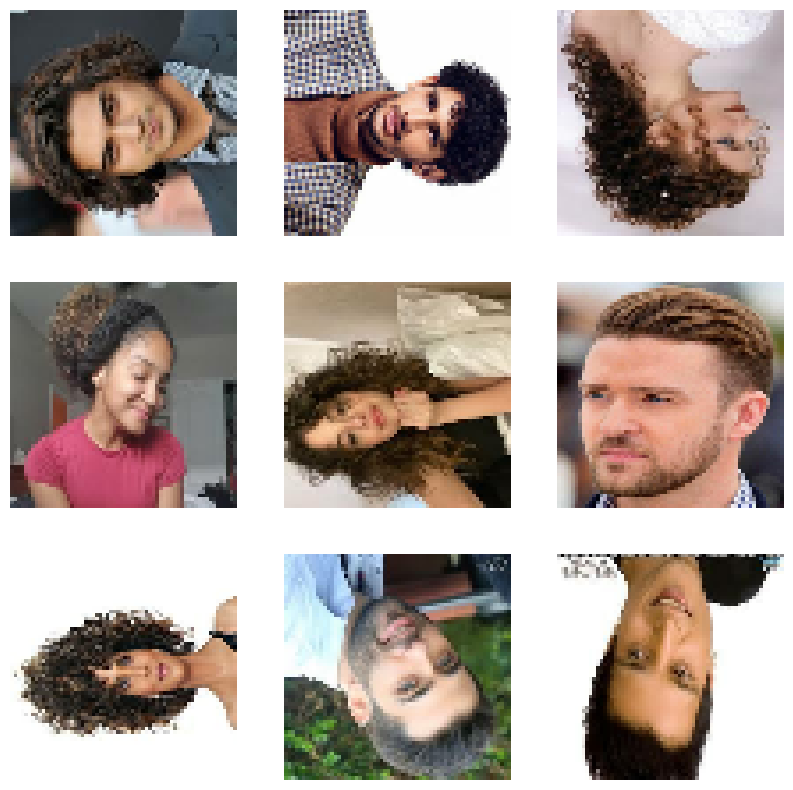

In [1050]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images, _ = augment_data(images[i], None)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images).astype("uint8"))
        plt.axis("off")
plt.show()

#### GPU Optimization

In [1051]:
from tensorflow import data as tf_data
# Configuring dataset for performance
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = augmented_train_ds.prefetch(tf_data.AUTOTUNE)
val_dataset = val_ds.prefetch(tf_data.AUTOTUNE)

## Model Architecture

In [1052]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.models import Sequential
# from keras.layers import Dense
# from tensorflow.keras import regularizers


# # Define your model architecture
# model = Sequential([
#     keras.Input(shape=image_size + (3,)),
#     layers.Rescaling(1.0 / 255),

#     layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.BatchNormalization(),
    
#     layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.BatchNormalization(),

#     layers.GlobalAveragePooling2D(),
    
#     layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dropout(0.5),
#     layers.Dense(3, activation="softmax")
# ])

# # Compile the model
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )
# model.summary()


In [1053]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers

# Define your model architecture
model = Sequential([
    keras.Input(shape=image_size + (3,)),
    layers.Rescaling(1.0 / 255),

    layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),

    # layers.Dense(units=32, activation="relu", kernel_regularizer=regularizers.l1_l2()), # 0.01 default
    # DropConnect(rate=0.25),  # Applying DropConnect
    # layers.Dense(3, activation="softmax")

    layers.Flatten(),
    layers.Dense(units=32, activation="relu", kernel_regularizer=regularizers.l1_l2()), # 0.01 default
    DropConnect(rate=0.25),  # Applying DropConnect
    layers.Dense(3, activation="softmax")
])


# Compile the model
model.compile(
    optimizer=keras.optimizers.Adamax(0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_71 (Rescaling)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_228 (Conv2D)             │ (None, 64, 64, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_229 (Conv2D)             │ (None, 64, 64, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_214               │ (None, 32, 32, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_204         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_230 (Conv2D)             │ (None, 32, 32, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_231 (Conv2D)             │ (None, 32, 32, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_215               │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_205         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_232 (Conv2D)             │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_216               │ (None, 8, 8, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_206         │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_74     │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_connect_58 (DropConnect)   │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,139 (152.89 KB)

 Trainable params: 38,883 (151.89 KB)

 Non-trainable params: 256 (1.00 KB)

In [1054]:
# import tensorflow as tf
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import layers

# # Load the pretrained VGG16 model without the top classification layers
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# # Freeze the pretrained layers
# base_model.trainable = False

# # Create a new model by adding your custom classification layers on top of the pretrained base
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(128, activation='relu'),
#     # Dropout(0.5),  # Adding dropout regularization
#     Dense(3, activation='softmax')
# ])

# # Compile the model with a lower learning rate

# model.compile(optimizer=keras.optimizers.Adam(1e-3),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

In [1055]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6)


In [1056]:
# Fine-tune the model
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.4080 - loss: 1.0709 - val_accuracy: 0.2872 - val_loss: 1.1122 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.4762 - loss: 1.0144 - val_accuracy: 0.3538 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.5211 - loss: 0.9795 - val_accuracy: 0.3385 - val_loss: 1.0947 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.5596 - loss: 0.9377 - val_accuracy: 0.4051 - val_loss: 1.0964 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5824 - loss: 0.9324 - val_accuracy: 0.3949 - val_loss: 1.0961 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.5769 - loss: 0.9281 - val_accuracy: 0.3949 - val_loss: 1.0838 - learning_rate: 0.0010
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.6002 - loss: 0.8889 - 

## Model Evaluation

In [1057]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
This image is 0.95 percent curly hair, 0.03 percent straight hair, and 0.02 percent wavy hair.


In [1058]:
import os
import random

# Set the directory containing your dataset
dataset_dir = "hair_types/Curly_Hair/"

# Get a list of all files in the dataset directory
file_list = os.listdir(dataset_dir)

# Choose a random file from the list
random_file = random.choice(file_list)

# Construct the path to the randomly chosen image
image_path = os.path.join(dataset_dir, random_file)

# Load the image
img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)

# Print the results
print(
    "For the randomly chosen image (%s), the predicted percentages are: Curly Hair: %.2f%%, Straight Hair: %.2f%%, Wavy Hair: %.2f%%."
    % (random_file, predictions[0][0] * 100, predictions[0][1] * 100, predictions[0][2] * 100)
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
For the randomly chosen image (images188.jpg), the predicted percentages are: Curly Hair: 45.32%, Straight Hair: 19.46%, Wavy Hair: 35.22%.
